In [1]:
from IPython.display import HTML
HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>
''')

# Altimetry

In [2]:
from IPython.display import HTML

%run ../_setup.py

import numpy as np
import datetime
import pyproj

from netCDF4 import Dataset, num2date
from OceanPy.animations import play2D

from gsw import f

%matplotlib notebook
import matplotlib.pyplot as plt

# import cmocean as cmo

In [42]:
# load altimetry data
input_file = os.path.join(datadir, 'external', 'ssh', 'SSH_OceanCurrent_137_-52.4_147_-48_199801-199804.nc')
ssh = Dataset(input_file)

loni, lati = ssh['LONGITUDE'][:], ssh['LATITUDE'][:]
lonlon, latlat = np.meshgrid(loni, lati)

# transform polar in cartesian coordinate system
UTM54 = pyproj.Proj('+proj=utm +zone=54F +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
xx, yy = pyproj.transform(WGS84, UTM54, lonlon, latlat)

# load bathymetry (1 arc-minute resolution)
bathy = Dataset(os.path.join(datadir, 'external', 'bathymetry', 'bodc_res1min', 
                             'GRIDONE_2D_137.0_-52.2_145.0_-48.0.nc'))

# determine time of the voyage
time = num2date(ssh['TIME'][:], ssh['TIME'].units)
begin = datetime.datetime(1998, 3, 10)
end = datetime.datetime(1998, 3, 28)
# np.where(time==begin)
timevoy = np.array([begin <= t <= end for t in time])

# calculate flow speed, relative vorticity and divergence
V = np.ma.masked_all(ssh['UCUR'].shape)
zeta, div = V.copy(), V.copy()
for t in range(len(time)):
    V[t,] = np.sqrt(ssh['UCUR'][t,]**2 + ssh['VCUR'][t,]**2)
    dvdx = np.gradient(ssh['VCUR'][t,])[1] / np.gradient(xx)[1]
    dudy = np.gradient(ssh['UCUR'][t,])[0] / np.gradient(yy)[0]
    
    dudx = np.gradient(ssh['UCUR'][t,])[0] / np.gradient(xx)[1]
    dvdy = np.gradient(ssh['VCUR'][t,])[1] / np.gradient(yy)[0]

    zeta[t,] = dvdx - dudy
    div[t,] = dudx + dvdy

# determine planetary vorticity
plan_vort = f(latlat)

# average dynamic height contours over time of the voyage
D = np.mean(ssh['GSL'][timevoy], axis=0)


In [ ]:
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())

anim = play2D(loni, lati, ssh['GSL'], time=time, mask=timevoy, type='contour',
              interval=200, save=False, savepath=os.path.join(outdir, 'ss9802'))
display_animation(anim)

In [ ]:
anim = play2D(loni, lati, V, time=time, mask=timevoy, cmin=0, cmax=0.6, cmap=cmo.cm.speed,
              interval=200, save=False, savepath=os.path.join(outdir, 'ss9802'))
display_animation(anim)

In [ ]:
anim = play2D(loni, lati, zeta, time=time, mask=timevoy, cmin=-2e-5, cmax=2e-5, cmap=cmo.cm.balance, interval=200)
display_animation(anim)

In [3]:
anim = play2D(loni, lati, div, time=time, mask=timevoy, cmin=-1.5e-5, cmax=1.5e-5, cmap=cmo.cm.delta, interval=200)
display_animation(anim)

NameError: name 'loni' is not defined

NameError: name 'loni' is not defined

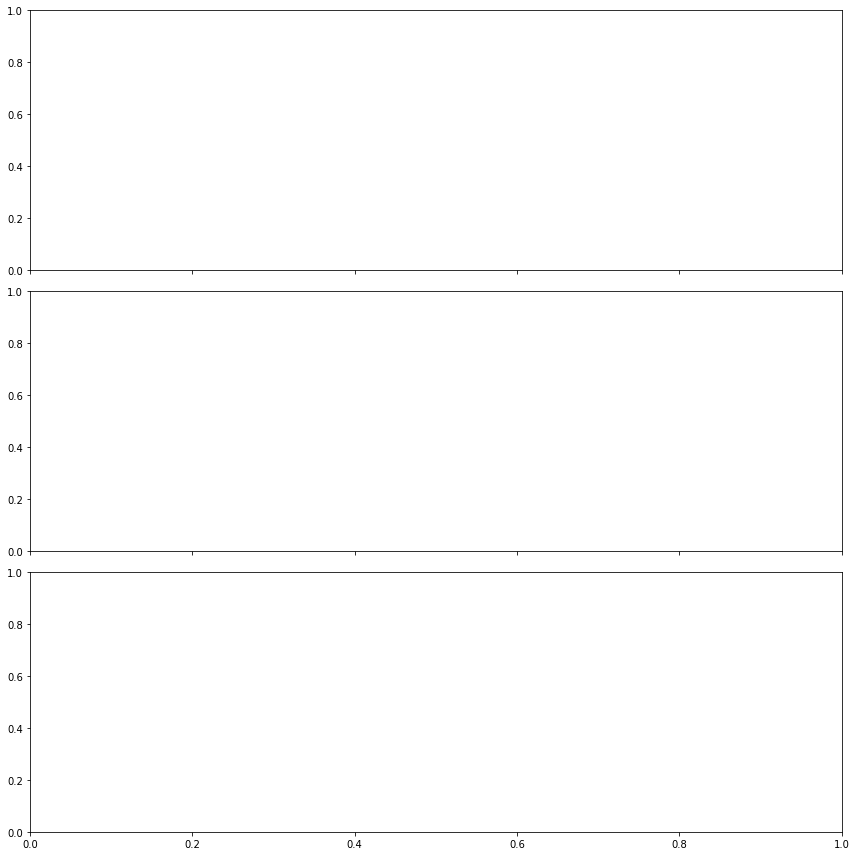

In [4]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
fig.tight_layout()

# plot flow speed field
vmin, vmax = 0, 0.8
axis=0
pcol = ax[axis].pcolor(loni, lati, np.mean(V[timevoy], axis=0), vmin=vmin, vmax=vmax, cmap=cmo.cm.speed)
plt.colorbar(pcol, ax=ax[axis])
ax[axis].set_title('Flow speed')

# # plot relative vorticity field
# vmin, vmax = -2e-5, 2e-5
axis=1
# pcol = ax[axis].pcolor(loni, lati, np.mean(zeta[timevoy], axis=0), vmin=vmin, vmax=vmax, cmap=cmo.cm.balance)
# plt.colorbar(pcol, ax=ax[axis])
# ax[axis].set_title('Relative vorticity')

# plot absolute vorticity field
# vmid= -1.12e-4 # f(-50.2)
vmin, vmax = -0.94e-4, -1.3e-4
axis=1
pcol = ax[axis].pcolor(loni, lati, plan_vort + np.mean(zeta[timevoy], axis=0), vmin=vmin, vmax=vmax, cmap=cmo.cm.balance)
plt.colorbar(pcol, ax=ax[axis])
ax[axis].set_title('Absolute vorticity')

# plot divergence field
vmin, vmax = -1.5e-5, 1.5e-5
axis=2
pcol = ax[axis].pcolor(loni, lati, np.mean(div[timevoy], axis=0), vmin=vmin, vmax=vmax, cmap=cmo.cm.delta)
plt.colorbar(pcol, ax=ax[axis])
ax[axis].set_title('Divergence')

bounds = np.linspace(1, 2, 11)
depths = np.linspace(-5000, -1000, 5)
for i in range(len(ax)):
    
    # plot dynamic height contours
    ct = ax[i].contour(loni, lati, np.mean(ssh['GSL'][timevoy], axis=0), bounds, colors='k')
    for ib, b in enumerate(bounds):
        if b in bounds[0::5]:
            zc = ct.collections[ib]
            plt.setp(zc, linewidth=3)
    ax[i].clabel(ct, bounds[0::5], inline=1, fontsize=10, fmt='%.1f', linewidth=3)
    
    # plot depth contours
    ax[i].contourf(bathy['lon'][:], bathy['lat'][:], bathy['elevation'][:], depths, 
                       cmap=plt.cm.binary_r, alpha=0.3)
    dc = ax[i].contour(bathy['lon'][:], bathy['lat'][:], bathy['elevation'][:], depths, 
                       colors='k', linewidths=0.2, linestyles='solid')
    ax[i].clabel(dc, depths, inline=1, fontsize=8, fmt='%.0f')

    # plot observations domain
    ax[i].fill([138, 143.5, 143.5, 138], [-51.75, -51.75, -48.75, -48.75], 
               facecolor='none', edgecolor='m', linewidth=3)
    
    ax[i].set_aspect('equal')

# fig.savefig(os.path.join(outdir, 'ss9802', 'altimetry.png'), transparent=True)#, bbox_inches='tight'

<IPython.core.display.Javascript object>


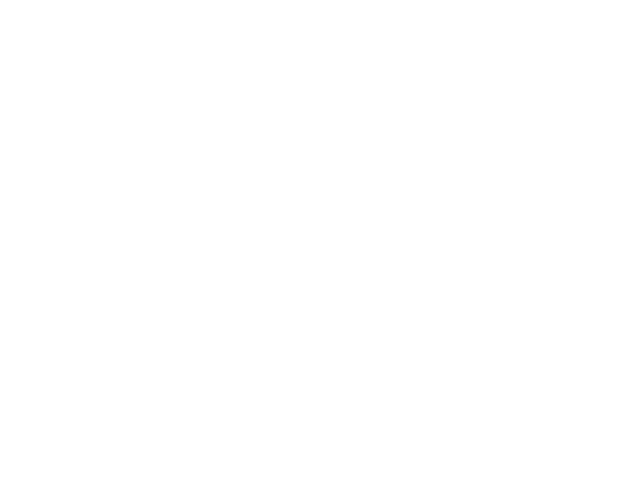

NameError: name 'bounds' is not defined

In [8]:
fig, ax = plt.subplots()
# plot dynamic height contours
ct = ax.contour(loni, lati, np.mean(ssh['GSL'][timevoy], axis=0), bounds, colors='k')
for ib, b in enumerate(bounds):
    if b in bounds[0::5]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=3)
ax.clabel(ct, bounds[0::5], inline=1, fontsize=10)
ax.axvline(ssh['LONGITUDE'][10], color='r')
ax.axhline(-48.75, color='gray')
ax.axhline(-51.75, color='gray')
print(ssh['LONGITUDE'][10])

## Hovmoller diagram

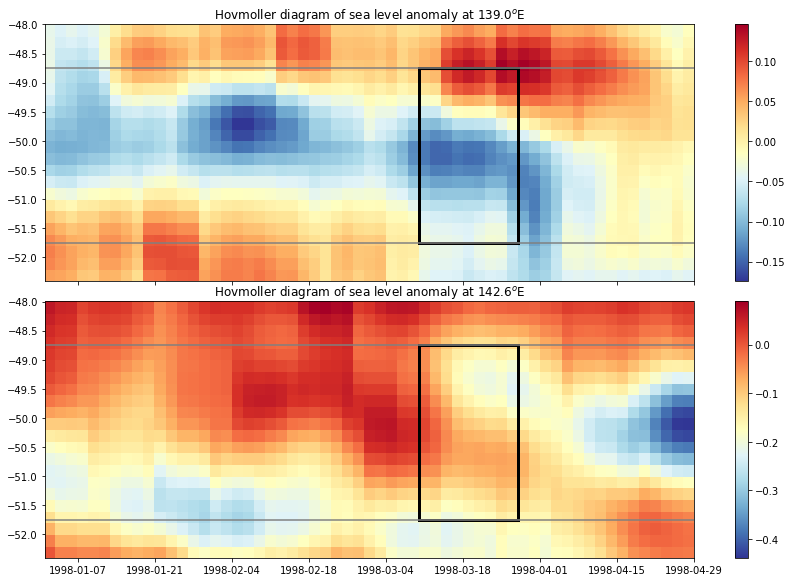

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.tight_layout()
pcol = ax[0].pcolormesh(time, ssh['LATITUDE'], ssh['GSLA'][:,:,10].T, cmap=plt.cm.RdYlBu_r)
plt.colorbar(pcol, ax=ax[0])
ax[0].set_title(r'Hovmoller diagram of sea level anomaly at %s$^o$E' % ssh['LONGITUDE'][10])

pcol = ax[1].pcolormesh(time, ssh['LATITUDE'], ssh['GSLA'][:,:,28].T, cmap=plt.cm.RdYlBu_r)
plt.colorbar(pcol, ax=ax[1])
ax[1].set_title(r'Hovmoller diagram of sea level anomaly at %s$^o$E' % ssh['LONGITUDE'][28])

# plot observations domain
tbeg, tend = time[np.where(time==begin)[0]], time[np.where(time==end)[0]]
for i in range(len(ax)):
    ax[i].fill([tbeg, tend, tend, tbeg], [-51.75, -51.75, -48.75, -48.75], facecolor='none', edgecolor='k', linewidth=3)

    ax[i].axhline(-48.75, color='gray')
    ax[i].axhline(-51.75, color='gray')
# fig.savefig(os.path.join(outdir, 'ss9802', 'hovmoller_gsla.png'), transparent=True)#, bbox_inches='tight'b

In [5]:
# for each timestep average longitudinal values from 138 - 145
hm = np.ma.masked_all(ssh['GSLA'].shape[:-1][::-1])
for it in range(len(time)):
    hm[:, it] = np.average(ssh['GSLA'][it,::], axis=1)

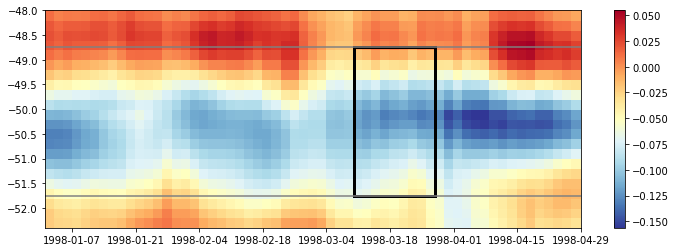

In [6]:
fig, ax = plt.subplots(figsize=(12, 4))
pcol = ax.pcolormesh(time, ssh['LATITUDE'], hm, cmap=plt.cm.RdYlBu_r)
plt.colorbar(pcol)

# plot observation domain
ax.fill([tbeg, tend, tend, tbeg], [-51.75, -51.75, -48.75, -48.75], facecolor='none', edgecolor='k', linewidth=3)
ax.axhline(-48.75, color='gray')
ax.axhline(-51.75, color='gray')


In [43]:
# for each timestep average latitudinal values from -48.6 - -51.8
hm = np.ma.masked_all(ssh['GSLA'][:,3:20,5:41].shape[0::2])
for it in range(len(time)):
    hm[it, :] = np.average(ssh['GSLA'][it,3:20,5:41], axis=0)

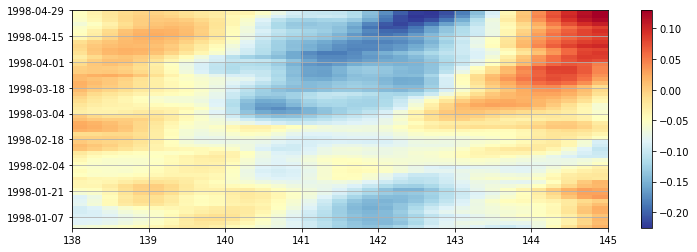

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))
pcol = ax.pcolormesh(ssh['LONGITUDE'][5:41], time, hm, cmap=plt.cm.RdYlBu_r)
plt.colorbar(pcol)
plt.grid()

# # plot observation domain
# ax.fill([tbeg, tend, tend, tbeg], [-51.75, -51.75, -48.75, -48.75], facecolor='none', edgecolor='k', linewidth=3)
# ax.axhline(-48.75, color='gray')
# ax.axhline(-51.75, color='gray')

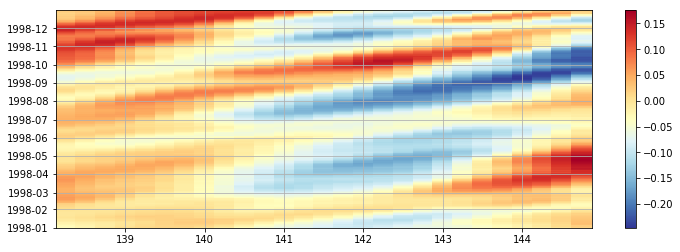

In [45]:
input_file = os.path.join(datadir, 'external', 'ssh', 'SEALEVEL_GLO_PHY_L4_REP_OBS_137_-52.4_147_-48_199801-199812.nc')
sl = Dataset(input_file)

time = num2date(sl['time'][:], sl['time'].units)

# for each timestep average latitudinal values from -48.6 - -51.8
hm = np.ma.masked_all(sl['sla'][:,2:-3,4:-9].shape[0::2])
for it in range(len(time)):
    hm[it, :] = np.average(sl['sla'][it,2:-3,4:-9], axis=0)

fig, ax = plt.subplots(figsize=(12, 4))
pcol = ax.pcolormesh(sl['longitude'][4:-9], time, hm, cmap=plt.cm.RdYlBu_r)
plt.colorbar(pcol)
plt.grid()